In [1]:
import pickle
import re
import pandas as pd
from plotnine import *

In [2]:
def convert_pickle_to_csv(filepath):

	"""Converts the olympic_results.pkl file to a csv"""

	new_csv_filepath = "data/olympic_results_2.csv"
	with open(filepath, "rb") as pkl_file:
		data_df = pickle.load(pkl_file)
		data_df.to_csv(new_csv_filepath)

convert_pickle_to_csv("data/olympic_results.pkl")

In [3]:
def check_df_similarity(df_1, df_2):

	"""Checks if olympic_results.csv and olympic_results.pkl
	have the same content"""
	return df_1.equals(df_2)

df_1 = pd.read_csv("data/olympic_results.csv")

# dropping hte first column of df_2 (index column)
df_2 = pd.read_csv("data/olympic_results_2.csv")

print(check_df_similarity(df_1, df_2))

False


In [4]:
results_df = pd.read_csv("data/olympic_results.csv")
medals_df = pd.read_csv("data/olympic_medals.csv")
athletes_df = pd.read_csv("data/olympic_athletes.csv")
hosts_df = pd.read_csv("data/olympic_hosts.csv")

# Nombre de médailles gagnées au cours du temps

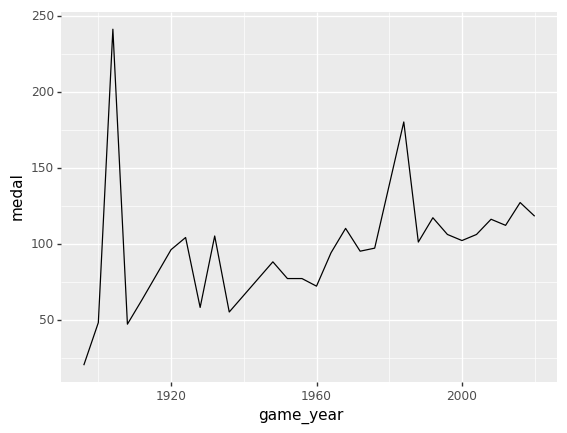

In [5]:
def get_medals_per_year(medals, host):
    
    df_medals = medals
    df_host = host

    df_medals = df_medals.merge(df_host, left_on='slug_game', right_on='game_slug', how="right")

    df_graph_medals = \
    df_medals.loc[(df_medals["country_3_letter_code"] == "USA") & (df_medals["game_season"] == "Summer")][
        ["game_year", "medal_type"]]

    df_graph_medals = df_graph_medals.groupby(by=["game_year"]).size().reset_index(name='medal')
    return df_graph_medals
    
def usa_medal_by_year(medals, host):
    
    df_graph_medals = get_medals_per_year(medals, host)
    myPlot = ggplot(df_graph_medals) + aes(x=df_graph_medals['game_year'], y=df_graph_medals["medal"]) + geom_line()
    print(myPlot)
    
usa_medal_by_year(medals_df.copy(), hosts_df.copy())

# Nombre d'athlètes engagés au cours du temps, au total et par sexe

In [6]:
#Afficher les différentes valeurs de la colonne "participant_type"
print(results_df['participant_type'].unique())

['GameTeam' 'Athlete']


In [7]:
def add_athletes_count_columns(results_df):
    
    """Ici, on ajoute six colonnes à la dataframe results_df :
    le nombre de femmes engagées sur l'épreuve, le nombre d'hommes
    engagés sur l'épreuve, et le nombre total d'athlètes.
    Lorsque le sexe de l'épreuve ne peut pas être déterminé,
    on laisse les deux premières colonnes à 0 et ne renseigne 
    que la trosième.
    Pour les épreuves en équipe, on ajoute aussi trois colonnes
    (équipes masculines, équipes féminines, équipes mixtes/indéterminées)"""
    
    men_teams_count_column = []
    women_teams_count_column = []
    total_teams_count_column = []
    male_athletes_count_column = []
    female_athletes_count_column = []
    total_athletes_count_column = []
    for index, row in results_df.iterrows():
        if row["participant_type"] == "Athlete" :
            if "women" in row["event_title"].lower():
                male_athletes_count_column.append(0)
                female_athletes_count_column.append(1)
                total_athletes_count_column.append(1)
                men_teams_count_column.append(0)
                women_teams_count_column.append(0)
                total_teams_count_column.append(0)
            elif "men" in row["event_title"].lower(): 
                male_athletes_count_column.append(1)
                female_athletes_count_column.append(0)
                total_athletes_count_column.append(1)
                men_teams_count_column.append(0)
                women_teams_count_column.append(0)
                total_teams_count_column.append(0)
            else: 
                male_athletes_count_column.append(0)
                female_athletes_count_column.append(0)
                total_athletes_count_column.append(1)
                men_teams_count_column.append(0)
                women_teams_count_column.append(0)
                total_teams_count_column.append(0)
        else:
            if "women" in row["event_title"].lower(): 
                male_athletes_count_column.append(0)
                female_athletes_count_column.append(0)
                total_athletes_count_column.append(0)
                men_teams_count_column.append(0)
                women_teams_count_column.append(1)
                total_teams_count_column.append(1)
            elif "men" in row["event_title"].lower(): 
                male_athletes_count_column.append(0)
                female_athletes_count_column.append(0)
                total_athletes_count_column.append(0)
                men_teams_count_column.append(1)
                women_teams_count_column.append(0)
                total_teams_count_column.append(1)

            else: 
                male_athletes_count_column.append(0)
                female_athletes_count_column.append(0)
                total_athletes_count_column.append(0)
                men_teams_count_column.append(0)
                women_teams_count_column.append(0)
                total_teams_count_column.append(1)
        
    results_df["male_athletes_participating"] = male_athletes_count_column
    results_df["female_athletes_participating"] = female_athletes_count_column
    results_df["total_athletes_participating"] = total_athletes_count_column
    results_df["male_teams_participating"] = men_teams_count_column
    results_df["female_teams_participating"] = women_teams_count_column
    results_df["total_teams_participating"] = total_teams_count_column
        
    return results_df
            
results_df = add_athletes_count_columns(results_df.copy())

In [8]:
# On filtre pour ne garder que les performances des athlètes et équipes américaines 
us_athletes_participating_df = results_df.query("country_3_letter_code == 'USA'")

years_column = []
# On ajoute une colonne qui contient l'année
for index, row in us_athletes_participating_df.iterrows():
    years_column.append(row["slug_game"][-4:])

us_athletes_participating_df["year"] = years_column

# On enlève toutes les lignes qui correspondent à des JO d'hiver
summer_games_df = hosts_df.query("game_season == 'Summer'")
final_df = pd.DataFrame()

for index, row in us_athletes_participating_df.iterrows():
    if row["slug_game"] in summer_games_df["game_slug"].values:
        final_df = final_df.append(row, ignore_index=True)


/tmp/ipykernel_22968/2155399962.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_22968/2155399962.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_22968/2155399962.py:17: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.


In [9]:
# On crée une dataframe avec une année par ligne qui additionne le nombre d'athlètes et d'équipes par année
years_df = pd.DataFrame()

years = final_df["year"].unique()

for y in years:
    per_year_df = final_df.query("year == @y")
    athletes_count = {}
    athletes_count["year"] = int(y)
    athletes_count["men_athletes_participating"] = per_year_df["male_athletes_participating"].sum()
    athletes_count["women_athletes_participating"] = per_year_df["female_athletes_participating"].sum()
    athletes_count["total_athletes_participating"] = per_year_df["total_athletes_participating"].sum()
    athletes_count["men_teams_participating"] = per_year_df["male_teams_participating"].sum()
    athletes_count["women_teams_participating"] = per_year_df["female_teams_participating"].sum()
    athletes_count["total_teams_participating"] = per_year_df["total_teams_participating"].sum()

    years_df = years_df.append(athletes_count, ignore_index=True)


/tmp/ipykernel_22968/2469173896.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_22968/2469173896.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_22968/2469173896.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_22968/2469173896.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_22968/2469173896.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_22968/2469173896.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

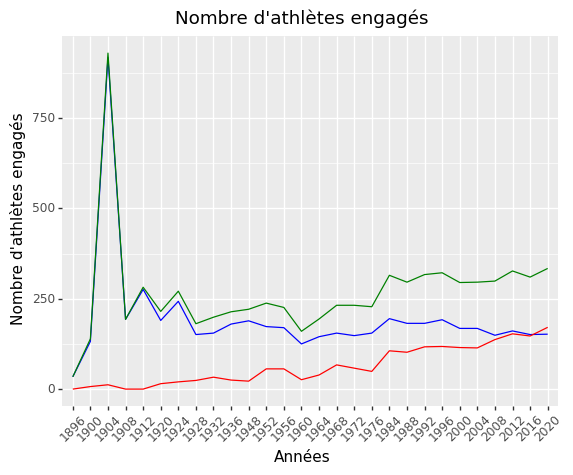

<ggplot: (8755563355887)>

In [10]:
# On peut maintenant tracer les courbes qui montrent 
# le nombre d'athlètes et d'équipes américaines qui ont 
# participé aux JO selon l'année

def get_athletes_per_year(years_df):
    
    athletes_per_year_df = years_df[["year", "men_athletes_participating", 
                        "women_athletes_participating", 
                        "total_athletes_participating"]]
    return athletes_per_year_df
    
def get_teams_per_year(years_df):
    
    teams_per_year_df = years_df[["year", "men_teams_participating", 
                        "women_teams_participating", 
                        "total_teams_participating"]]
    return teams_per_year_df


athletes_per_year_df = get_athletes_per_year(years_df)
teams_per_year_df = get_teams_per_year(years_df)

ggplot(mapping=aes(x="years", group=1), data=athletes_per_year_df) +\
geom_line(aes(y="men_athletes_participating"), color='blue') +\
geom_line(aes(y="women_athletes_participating"), color='red') +\
geom_line(aes(y="total_athletes_participating"), color='green') +\
labs(x="Années", y="Nombre d'athlètes engagés") +\
theme(axis_text_x=element_text(rotation=45)) +\
ggtitle("Nombre d'athlètes engagés")



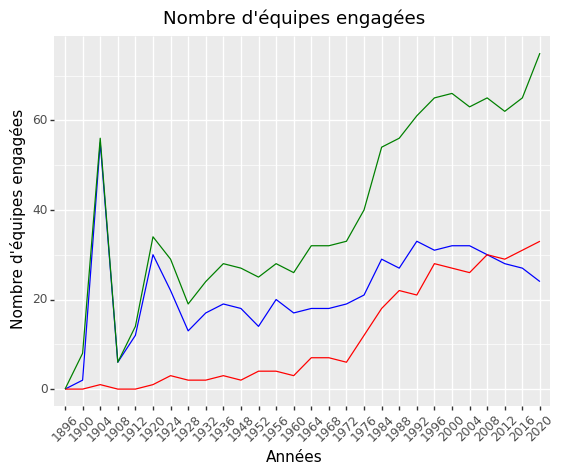

<ggplot: (8755436086185)>

In [11]:
ggplot(mapping=aes(x="years", group=1), data=teams_per_year_df) +\
geom_line(aes(y="men_teams_participating", show_legend=True), color='blue') +\
geom_line(aes(y="women_teams_participating"), color='red') +\
geom_line(aes(y="total_teams_participating"), color='green') +\
labs(x="Années", y="Nombre d'équipes engagées") +\
theme(axis_text_x=element_text(rotation=45)) +\
ggtitle("Nombre d'équipes engagées")

# Distribution de l'âge des participants pour toutes les éditions

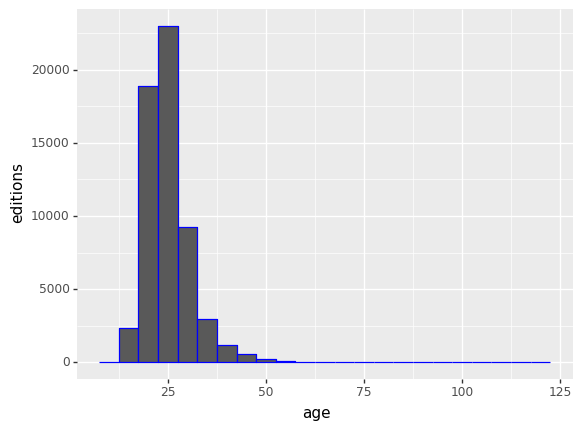

In [14]:
def age_by_edition(df_athletes, df_host):

    df_graph_age = df_athletes.merge(df_host, left_on='first_game' , right_on='game_name', how="right")
    graph_age = df_graph_age.loc[(df_graph_age["game_season"] == "Summer") & (df_graph_age["athlete_year_birth"].notna()) ][["first_game", "athlete_year_birth", "athlete_full_name"]]
    graph_age = pd.DataFrame(graph_age).reset_index()

    graph_age["athlete_year_birth"] = [int(graph_age["first_game"].iloc[key][-4:]) - int(col) for key, col in graph_age["athlete_year_birth"].items()]
    ## je retire les athletes qui ont moins de 10 ans car les données ne me 
    # semblait pas coherentes par avec des retour a -80ans
    graph_age = graph_age.loc[graph_age["athlete_year_birth"] > 10]


    graph_age.to_csv("look_me")

    myPlot = (
                ggplot(graph_age, aes(x='athlete_year_birth', y=after_stat('count')))
                + geom_histogram(binwidth=5, color="blue")
                + xlab("age")
                + ylab("editions")

        )
    print(myPlot)
    
age_by_edition(athletes_df.copy(), hosts_df.copy())

# Nombre de médailles gagnées pour chacun des 10 sportifs ayant gagné le plus de médailles

In [ ]:
def get_medals_per_athlete(results_df, hosts_df):
    
    # On commence par éliminer toutes les lignes qui concernent des pays
    # autres que les USA
    medals_per_athlete = {'names' : [],
                          'gold': [],
                          'silver': [],
                          'bronze': [],
                          'total': []}
    us_athletes_participating_df = results_df.query("country_3_letter_code == 'USA'")
    summer_games_df = hosts_df.query("game_season == 'Summer'")
    summer_games_list = summer_games_df["game_slug"].values


    # Pour chaque ligne où une médaille a été gagnée, récupérer le nom du ou des athlètes
    # Pour chaque athlète, regarder si il a déjà une ligne dans medals_per_athlete
    # Si oui, on actualise les valeurs des colonnes gold, silver, bronze et total en conséquence
    # Si non, on rajoute une nouvell ligne
    
    for index, row in us_athletes_participating_df.iterrows():
        # On vérifie que l'athlète ou l'équipe a gagné une médaille sur l'épreuve,
        # et que l'épreuve concerne des JO d'été
        if not pd.isnull(row["medal_type"]) and row["slug_game"] in summer_games_list:
            if row["participant_type"] == "Athlete":
                name = row["athlete_full_name"]
                
                match row["medal_type"]:
                    case "GOLD":
                        gold = 1
                        silver = 0
                        bronze = 0
                        total = 1
                    case "SILVER":
                        gold = 0
                        silver = 1
                        bronze = 0
                        total = 1
                    case "BRONZE":
                        gold = 0
                        silver = 0
                        bronze = 1
                        total = 1
                        
                if name not in medals_per_athlete["names"]:
                    medals_per_athlete["names"].append(name)
                    medals_per_athlete["gold"].append(gold)
                    medals_per_athlete["silver"].append(silver)
                    medals_per_athlete["bronze"].append(bronze)
                    medals_per_athlete["total"].append(total)

                else:
                    index = medals_per_athlete["names"].index(name)
                    medals_per_athlete["gold"][index] += gold
                    medals_per_athlete["silver"][index] += silver
                    medals_per_athlete["bronze"][index] += bronze
                    medals_per_athlete["total"][index] += total
            
            else:
                
                if pd.isnull(row["athletes"]): continue
                re_pattern = re.compile(r"[^a-z, ]", re.I)
                team_list = re.sub(re_pattern, "", row["athletes"]).replace("  ", " ").strip()
                team_list = team_list.split(",")
                for athlete in team_list:
                    athlete = athlete.strip()
                    if athlete.startswith("http"): continue
                    
                    name = athlete
                    match row["medal_type"]:
                        case "GOLD":
                            gold = 1
                            silver = 0
                            bronze = 0
                            total = 1
                        case "SILVER":
                            gold = 0
                            silver = 1
                            bronze = 0
                            total = 1
                        case "BRONZE":
                            gold = 0
                            silver = 0
                            bronze = 1
                            total = 1
                    
                    
                    if name not in medals_per_athlete["names"]:
                        medals_per_athlete["names"].append(name)
                        medals_per_athlete["gold"].append(gold)
                        medals_per_athlete["silver"].append(silver)
                        medals_per_athlete["bronze"].append(bronze)
                        medals_per_athlete["total"].append(total)

                    else:
                        index = medals_per_athlete["names"].index(name)
                        medals_per_athlete["gold"][index] += gold
                        medals_per_athlete["silver"][index] += silver
                        medals_per_athlete["bronze"][index] += bronze
                        medals_per_athlete["total"][index] += total
            
                            
    medals_per_athlete_df = pd.DataFrame(medals_per_athlete)           
    return medals_per_athlete_df
                            
    
medals_per_athlete_df = get_medals_per_athlete(results_df.copy(), hosts_df.copy())
medals_per_athlete_df.sort_values(by=["total", "gold", "silver", "bronze"], inplace=True, ascending=False)
top_ten = medals_per_athlete_df.head(10)

# Un nom est manquant dans le top 10 des athlètes.
# Après quelques recherches sur internet, on constate 
# qu'il s'agit de Ryan Lochte. Il est ajouté manuellement
# dans la dataframe :
top_ten.at[870, 'names'] = "Ryan Lochte"
print(top_ten)


In [ ]:
def draw_barplot(top_ten):
    
    barplot = (ggplot(mapping=aes(x="names", y="total"),data=top_ten) +\
                geom_bar(stat="identity") +\
                xlab("Athlètes") +\
                ylab("Nombre de médailles") +\
                ggtitle("Nombre de médailles gagnées par les 10 athlètes les plus médaillés") +\
                theme(axis_text_x=element_text(rotation=45))
              )
    print(barplot)

    
draw_barplot(pd.DataFrame(top_ten[["names", "total"]]))


# Évolution de la place de l'athlète le plus médaillé sur chacune des marches du podium en fonction de son âge

In [ ]:
def best_athlete_medal_by_year(df_medals, df_host):

    medal_of_honor = df_medals.merge(df_host, left_on='slug_game', right_on='game_slug', how="right")

    medal_of_honor = medal_of_honor.loc[(medal_of_honor["country_3_letter_code"] == "USA") \
                                        & (medal_of_honor["game_season"] == "Summer")].reset_index()

    athlete_of_honor = medal_of_honor.groupby(by=["athlete_full_name"]).medal_type.size()\
        .reset_index(name='medals').sort_values(by="medals", ascending=False).iloc[0]["athlete_full_name"]


    medal_of_honor = medal_of_honor.loc[medal_of_honor["athlete_full_name"] == athlete_of_honor]

    medal_of_honor["gold"] = [1 if medal == "GOLD" else 0 for medal in medal_of_honor["medal_type"]]
    medal_of_honor["silver"] = [1 if medal == "SILVER" else 0 for medal in medal_of_honor["medal_type"]]
    medal_of_honor["bronze"] = [1 if medal == "BRONZE" else 0 for medal in medal_of_honor["medal_type"]]

    medal_of_honor = medal_of_honor.groupby(by="game_year")["gold", "silver", "bronze"].sum().reset_index()

    myPlot = (
                ggplot(medal_of_honor)
                + geom_line(aes(x='game_year', y="gold"), color="#a67c00",size=1.5)
                + geom_line(aes(x='game_year', y="silver"), color="#575757",size=1.5)
                + geom_line(aes(x='game_year', y="bronze"), color="#A97142",size=1.5)
                + xlab("Years")
                + ylab("Medals")

    )
    print(myPlot)
    
best_athlete_medal_by_year(medals_df.copy(), hosts_df.copy())

# Nombre de médailles gagnées en fonction du nombre de participants engagés

In [ ]:
medals_per_year = get_medals_per_year(medals_df.copy(), hosts_df.copy())
athletes_per_year = get_athletes_per_year(years_df)

medals_per_year = medals_per_year.rename(columns={"game_year": "year"})
merged_df = pd.merge(medals_per_year, athletes_per_year)
merged_df.drop(["men_athletes_participating", "women_athletes_participating", "year"], inplace=True, axis=1)

myPlot = (
            ggplot(merged_df)
            + aes(y='medal', x="total_athletes_participating")
            + xlab("Athlètes engagés")
            + ylab("Nombre de médailles")
            + geom_point()

        )
print(myPlot)




# Nombre d'athlètes engagés par sport au cours du temps